In [1]:
%matplotlib inline

In [2]:
from fenics import *
from dolfin_adjoint import *
from collections import OrderedDict
from matplotlib import pyplot as plt
import numpy as np

In [3]:
data = Expression("16*x[0]*(x[0]-1)*x[1]*(x[1]-1)*sin(pi*t)", t=0, degree=4)
nu = Constant(1e-5)

In [4]:
mesh = UnitSquareMesh(8, 8)
V = FunctionSpace(mesh, "CG", 1)

In [5]:
dt = Constant(0.1)
T = 2

In [6]:
ctrls = OrderedDict()
t = float(dt)
while t <= T:
    ctrls[t] = Function(V)
    t += float(dt)

In [7]:
def solve_heat(ctrls):
    u = TrialFunction(V)
    v = TestFunction(V)

    f = Function(V, name="source")
    u_0 = Function(V, name="solution")
    d = Function(V, name="data")

    F = ( (u - u_0)/dt*v + nu*inner(grad(u), grad(v)) - f*v)*dx
    a, L = lhs(F), rhs(F)
    bc = DirichletBC(V, 0, "on_boundary")

    t = float(dt)

    j = 0.5*float(dt)*assemble((u_0 - d)**2*dx)

    while t <= T:
        # Update source term from control array
        f.assign(ctrls[t])

        # Update data function
        data.t = t
        d.assign(interpolate(data, V))

        # Solve PDE
        solve(a == L, u_0, bc)

        # Implement a trapezoidal rule
        if t > T - float(dt):
           weight = 0.5
        else:
           weight = 1

        j += weight*float(dt)*assemble((u_0 - d)**2*dx)

        # Update time
        t += float(dt)

    return u_0, d, j

In [8]:
u, d, j = solve_heat(ctrls)

In [9]:
alpha = Constant(1e-1)
regularisation = alpha/2*sum([1/dt*(fb-fa)**2*dx for fb, fa in
    zip(list(ctrls.values())[1:], list(ctrls.values())[:-1])])

In [10]:
J = j + assemble(regularisation)
m = [Control(c) for c in ctrls.values()]

In [11]:
rf = ReducedFunctional(J, m)
opt_ctrls = minimize(rf, options={"maxiter": 50})

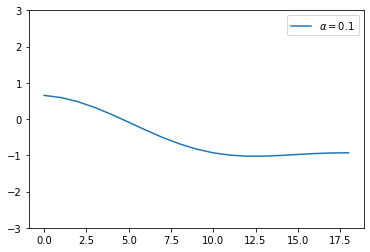

In [19]:
x = [c((0.5, 0.5)) for c in opt_ctrls]
plt.plot(x, label=r"$\alpha={}$".format(float(alpha)))
plt.ylim([-3, 3])
plt.legend()
plt.show()

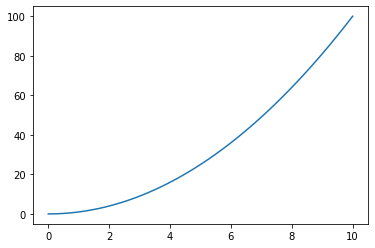

In [13]:
xl = np.linspace(0, 10, 100)
f = lambda x: x**2
plt.figure()
plt.plot(xl, f(xl))
plt.show()

In [25]:
float(dt)

0.1

In [39]:
u.vector().max()

0.0

In [33]:
len(ctrls)

19

In [34]:
19*float(dt)

1.9000000000000001